# Designing Interpretable Neural Networks
> A Neural Network with many layers and non-linear activation functions is difficult to interpret. However, that doesn't mean all NNs are opaque. Generalized Linear Models and Generalized Additive Models are classic transparent approaches to supervised learning. This post builds off of those approaches to demonstrate that it's possible to design Neural Networks that are just as transparent!

- toc: true 
- badges: true
- comments: true
- categories: [transparency]
- image: images/nnflow.png
- show_description: false
- annotations: true

In [1]:
#hide
#necessary packages for the notebook
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#custom matplotlib stylesheet for the blog
plt.style.use('blog')

Most supervised prediction problems can be described as learning some function $f$ that minimizes the error-term ($\epsilon$) to the equation $y = f(X) + \epsilon$, where $X$ is the input features and $y$ is the target prediction. This blog post will explore methods to devise neural architectures to learn such functions, with the additional goal of making them as transparent as linear models. However, prior to jumping into such architectures, it's important to understand the foundation of classic transparent approaches, starting from the simplest linear models. 

The next section provides the necessary background to understand how the building blocks of neural networks are related to linear models. Then, we can drop the restriction of linearity with Generalized Additive Models (GAMs), and explore building transparent neural networks.

# Linear Models

Different algorithms are sufficient for learning different families of functions. For example, simple linear models can only learn to make predictions according to functions of the form:

$$y = X^T\beta + \epsilon = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_n X_n + \epsilon$$

Where $\beta_i$ represents learned coefficients with respect to $X_i$.

## Linear Regression

Linear regression is arguably the simplest of the linear models, and comes with four assumptions:

1. **Linearity**: The relationship between $X$ and the mean of $Y$ is linear.
2. **Independence**: $X_i$ and $X_j$ are independent of eachother for all $i \neq j$.
3. **Normality**: $y$ given any $X$ comes from a normal distribution.
4. **Homoscedasticity**: The variance of residual is the same for any value of $X$.

These assumptions can be nicely described by one math equation:

$$
\begin{align}
y & \in \mathcal{N}(X^T\beta, \sigma^2 I) \\
& \Rightarrow \mathbb{E}[y|X] = X^T\beta
\end{align}
$$

However, these assumptions are quite rigid for the real world. Many datasets and/or problem spaces do not conform to these restrictions. So why do we still use linear regression when we have algorithms that can comparably perform the regression task without such rigid assumptions? The common answers to this question are:

1. **Occam's Razor**: Don't add complexity without necessity.    
2. **Little Data**: Ordinary Least Squares (OLS) is an estimation method for linear regression with a closed form solution{% fn 1 %}.
3. **Interpretability**: The prediction $y$ can always be explained with respect to the input features $X$ connected to the learned coefficients $\beta$.

Today, we are going to stick with the notion that transparency is of the utmost importance, and assume we have a significant amount of data. Whatever the model is, it must be able to produce feature-wise explanations that are useful. However, contrary to what you may have heard, these models don't need to be exactly linear as described above in order to be comparably interpretable.

## Generalized Linear Models

There are three components to any Generalized Linear Model (GLM):

1. **Random Component**: The probability distribution of $y$ (typically belonging to the exponential family{% fn 2 %}).
2. **Systematic Component**: the system of explanatory variables for predicting the random component (often $X^T\beta$).
3. **Link Function**: A function $g$ that links systematic component and the random component.

This yields the following general equation for GLMs:

$$g(\mathbb{E}[y|X]) = X^T\beta + \epsilon$$

Observe that if the random component is a normal distribution with a constant variance, and the link function is the identity function ($g(y) = y$), then the GLM is exactly linear regression! Hence the functions that GLMs can describe are simply a superset of the functions linear regression can describe. Furthermore, recognize that the random component loosens the constraint of normality, and that the link function alters the constraint of linearity. The relationship between $X$ and the mean of $y$ can be non-linear as long as the relationship between $X$ and the mean of $g(y)$ is linear. Lastly, the residuals are allowed to be heteroscedastic. The only restriction from linear regression that fully remains is the independence of the explanatory variables. 

### The Link Function

Non-normal random components necessitate a link function. The intuition behind a link function is that it transforms the distribution of $y$ to the range $(-\infty,+\infty)$. 


However, not all of these distributions range from $-\infty$ to $+\infty$, which is necessary for solving regression problems in the linear form $y = X^T\beta$. In order for us to maintain a linear model, we transform the mean of the distribution ( $\mu(x) = \mathbb{E}[y|X]$ ) using a specified function $g$. $g$ is called the link function.

$$g(\mu(x)) = X^T\beta + \epsilon$$

Observe that this also loosens the constraints of linearity. Recall that $\mu(x)$ is just our expectation for $y$ given $X$. So, if we substitute back $y$, and take the inverse to get rid of $g$ in relationship to $y$, we get:

$$y = g^{-1}(X^T\beta) + \epsilon$$

Hence the relationship between $y$ and $X$ is no longer required to be exactly linear. However, the relationship between the resulting $g(y)$ transformed by the link function and $X$ must be linear. 

Note that this clarification implies that L $g$ is the identity function $g(\mu) = \mu$, then the GLM is just normal linear regression. 

### Maximum Likelihood Estimation

Note: OLS = MLE under normality constraint

### Example: Logistic Regression

Logistic regression is actually a GLM! Let's say we're trying to predict some binary variable, which means that $y$ will be either 0 or 1. This can be described by a bernoulli distribution. In order to squash the regression results to be between 0 and 1, we use the logit link function $g(\mu) = log(\frac{\mu}{1 - \mu})$.

And GLMs are as easy as that! Given the expected distribution of your problem, you determine a link function that will properly transform your data to the right space. And then you can fit a simple linear model: $y = X^T\beta$.

## Relating to Neural Networks

Note: MLE -> crossentropy

![](https://ryansaxe.com/images/nnflow.png)

### Link Function -> Activation Function

### Maximum Likelihood Estimation -> Loss Function

### Code Example

In [2]:
#hide
#set up parameters to generate 3 normally distributed columns
columns = list('abc')
beta = [1, 1, 1]
bias = 0.0
size = 100000
mean = 5.0
std = 1.0
#create the dataset
data = {
    col: np.random.normal(
        size=size, loc=mean, scale=std
    ) for col in columns
}
X = pd.DataFrame(data)
betaX = X.copy()
for i,col in enumerate(columns):
    betaX[col] = X[col] * beta[i]
y_logistic = ((bias + betaX.sum(1)) < betaX.sum(1).mean()).astype(float)
y_linear = bias + betaX.sum(1)
#X.assign(target=y).head()

In [3]:
class Regression(tf.keras.Model):
    def __init__(
        self,
        name=None,
        style='linear'
    ):
        super().__init__(name=name)
        # linear regression uses the identity as the link function
        #    and the inverse of the identity is a linear activation
        if style.lower() == 'linear':
            activation = 'linear'
        # logistic regression uses the logit link function, and the
        #    inverse of logit is a sigmoid activation function
        elif style.lower() == 'logistic':
            activation = 'sigmoid'
        # no other options are supported
        else:
            raise ValueError('input style only supports two options: linear or logistic')
        # pass input directly to the output layer --- no hidden layers
        self.output_layer = tf.keras.layers.Dense(1, activation=activation)
    
    def call(self, x, training=None):
        return self.output_layer(x)

In [4]:
#logistic regression setup
logistic_reg = Regression(style='logistic')
logistic_reg.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['mean_absolute_error']
)
hist = logistic_reg.fit(
    X.to_numpy(),
    y_logistic.to_numpy(),
    epochs=20,
    batch_size=32,
)

Train on 100000 samples
Epoch 1/20
100000/100000 [==============================] - 4s 37us/sample - loss: 0.7754 - mean_absolute_error: 0.4888
Epoch 2/20
100000/100000 [==============================] - 3s 34us/sample - loss: 0.6278 - mean_absolute_error: 0.4604
Epoch 3/20
100000/100000 [==============================] - 3s 34us/sample - loss: 0.5729 - mean_absolute_error: 0.4327
Epoch 4/20
100000/100000 [==============================] - 3s 34us/sample - loss: 0.5302 - mean_absolute_error: 0.4069
Epoch 5/20
100000/100000 [==============================] - 3s 34us/sample - loss: 0.4937 - mean_absolute_error: 0.3836
Epoch 6/20
100000/100000 [==============================] - 3s 34us/sample - loss: 0.4624 - mean_absolute_error: 0.3629
Epoch 7/20
100000/100000 [==============================] - 3s 34us/sample - loss: 0.4352 - mean_absolute_error: 0.3443
Epoch 8/20
100000/100000 [==============================] - 3s 34us/sample - loss: 0.4114 - mean_absolute_error: 0.3277
Epoch 9/20
10000

In [5]:
#hide_input
print('binary crossentropy loss:',hist.history['loss'][-1],'\tmean absolute error:',hist.history['mean_absolute_error'][-1])

binary crossentropy loss: 0.26264412118434904 	mean absolute error: 0.21618827


In [6]:
linear_reg = Regression(style='linear')
linear_reg.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)
hist = linear_reg.fit(
    X.to_numpy(),
    y_linear.to_numpy(),
    epochs=20,
    batch_size=32,
)

Train on 100000 samples
Epoch 1/20
100000/100000 [==============================] - 4s 35us/sample - loss: 16.7596 - mean_absolute_error: 2.5893
Epoch 2/20
100000/100000 [==============================] - 3s 32us/sample - loss: 0.5011 - mean_absolute_error: 0.5516
Epoch 3/20
100000/100000 [==============================] - 3s 33us/sample - loss: 0.0413 - mean_absolute_error: 0.1400
Epoch 4/20
100000/100000 [==============================] - 3s 33us/sample - loss: 0.0023 - mean_absolute_error: 0.0365
Epoch 5/20
100000/100000 [==============================] - 3s 33us/sample - loss: 9.4708e-05 - mean_absolute_error: 0.0057
Epoch 6/20
100000/100000 [==============================] - 3s 33us/sample - loss: 1.6401e-09 - mean_absolute_error: 1.3697e-05
Epoch 7/20
100000/100000 [==============================] - 3s 32us/sample - loss: 1.4325e-07 - mean_absolute_error: 1.0512e-04
Epoch 8/20
100000/100000 [==============================] - 3s 31us/sample - loss: 1.8288e-07 - mean_absolute_error

In [7]:
#hide_input
print('mean squared error:',hist.history['loss'][-1],'\tmean absolute error:',hist.history['mean_absolute_error'][-1])

mean squared error: 1.9702294863463975e-07 	mean absolute error: 0.00019862552


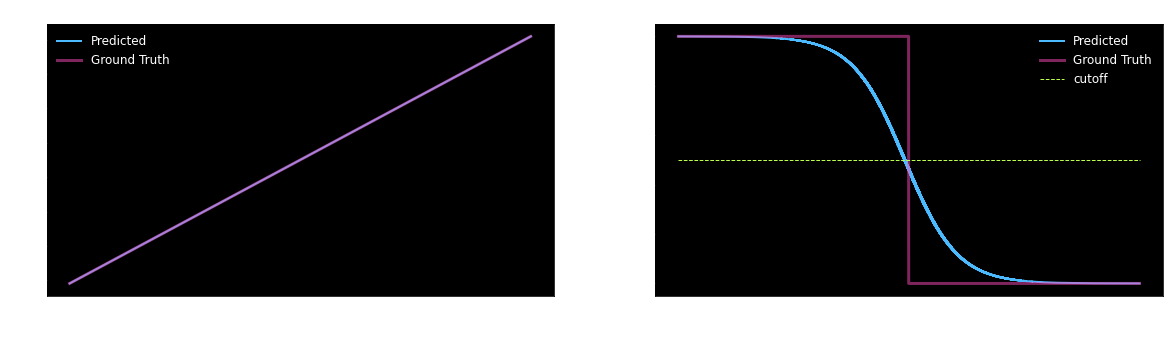

In [8]:
#hide_input
fig, axes = plt.subplots(1, 2)

X['target'] = betaX.sum(1)
x_sorted = X.sort_values(by='target')
y_before_label = bias + x_sorted['target']
test_y = (y_before_label < x_sorted['target'].mean()).astype(float).to_numpy()
test_X = x_sorted[columns].to_numpy(dtype=np.float32)

axes[0].plot(y_before_label, linear_reg(test_X), label="Predicted", lw=2)
axes[0].plot(y_before_label,y_before_label,label="Ground Truth", alpha=0.5)
axes[0].legend()
axes[0].set_title('Basic Linear Regression')
axes[0].set_xlabel('Sum of input features', c='white')
axes[0].set_ylabel('Target feature', c='white')

axes[1].plot(y_before_label, logistic_reg(test_X), label="Predicted", lw=2)
axes[1].plot(y_before_label,test_y,label="Ground Truth", alpha=0.5)
axes[1].plot([y_before_label.min(),y_before_label.max()], [0.5, 0.5], ls="--", lw=1, label="cutoff")
axes[1].legend()
axes[1].set_title('Basic Logistic Regression')
axes[1].set_xlabel('Sum of input features', c='white')
axes[1].set_ylabel('Target feature', c='white')
plt.show()

In [9]:
#hide
#set up parameters to generate 3 normally distributed columns
columns = ['a','b','c']
size = 1000000
mean = 0.0
#set to 1.333 so that 3 stds is at around 4
std = 1.0
#create the dataset
data = {
    col: np.random.normal(
        size=size, loc=mean, scale=std
    ) for col in columns
}
df = pd.DataFrame(data)
#apply nonlinear transforms to the data
def piecewise_crazy(x):
    x_ = abs(x)
    if x_ > 2:
        return x ** 3
    elif x_ > 1:
        return x ** 4 * 10
    else:
        return x ** 5 * 100
functions = {
    'a': lambda x: piecewise_crazy(x),
    'b': lambda x: x**4 + x**3 - 10 * x**2 + x,
    'c': lambda x: 10 / ((abs(x) ** 0.5) + 1e-1),
}
for col in columns:
    df[f'{col}_transform'] = df[col].apply(functions[col])
#set up a prediction task where the target is a composition of
#    the nonlinear transforms, but the training data is the normally
#    distributed data prior to being transformed    
X = df[[c for c in df.columns if not c.endswith('_transform')]]
y = df[[c for c in df.columns if c.endswith('_transform')]].sum(1)
#X.assign(target=y).head()

# Generalized Additive Models


Generalized Additive Models (GAMs) take another step towards reducing the restrictions within linear models. There are two modifications that GAMs make to classic GLMs, which truly moves from rigid assumptions to flexible modeling:

1. Full elimination of the linearity restriction.

    GAMs wrap each component $X_i$ with a function $h_k$, where $h_k$ is some learned function that can be non-linear, but must be smooth (differentiable everywhere). It also can be non-parametric.
    
2. A change to the independence criterion.

    Linear models make the assumption that $X_i$ and $X_j$ are independent forall $i \neq j$. Additive models don't have this property, however we assume that which features interact are known apriori. This means that the systematic component can be an equation that contains non-linear feature interaction like $h_k(X_i,X_j, \cdots)$.
    
Hence, equations for GAMs look like this:

$$g(\mu(X)) = \beta_0 + \beta_1 h_1(X_1) + \beta_2 h_2(X_2, X_3) + \cdots + \beta_m h_m(X_n) + \epsilon$$

Technically, this makes GLMs a special case of GAMs where all functions $h$

## Fitting Smooth Functions

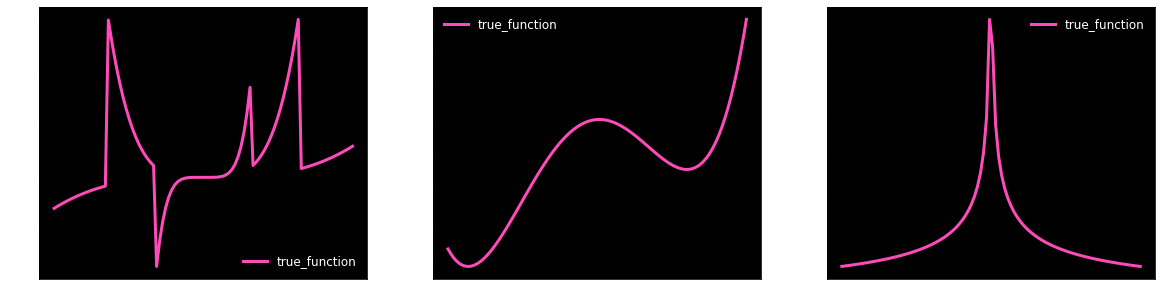

In [10]:
#hide_input
fig, axes = plt.subplots(1, len(X.columns))
for f_idx, column in enumerate(X.columns):
    ax = axes[f_idx]
    start = np.quantile(df[column],0.999)
    end = np.quantile(df[column],0.001)
    test_x = np.expand_dims(np.linspace(start,end,100,dtype=np.float32),axis=1)
    function = functions[column]
    true_y = np.asarray([function(x) for x in test_x])
    ax.plot(test_x, true_y, label="true_function", color=(1.0,75.0/255.0,186.0/255.0))
    ax.legend()

In [11]:
from pygam import LinearGAM
from pygam import s as spline
#fit to 20 splines of degree 3, with a low smoothing penalty 
# and no further constraints to each of the three features
gam = LinearGAM(spline(0) + spline(1) + spline(2)).fit(X, y)

In [12]:
#hide
mae = tf.keras.metrics.MeanAbsoluteError()
mse = tf.keras.metrics.MeanSquaredError()
yhat = gam.predict(X)

In [13]:
#hide_input
print('mean squared error:',mse(yhat, y).numpy(),'\tmean absolute error:',mae(yhat, y).numpy())

mean squared error: 411.93893 	mean absolute error: 13.017934


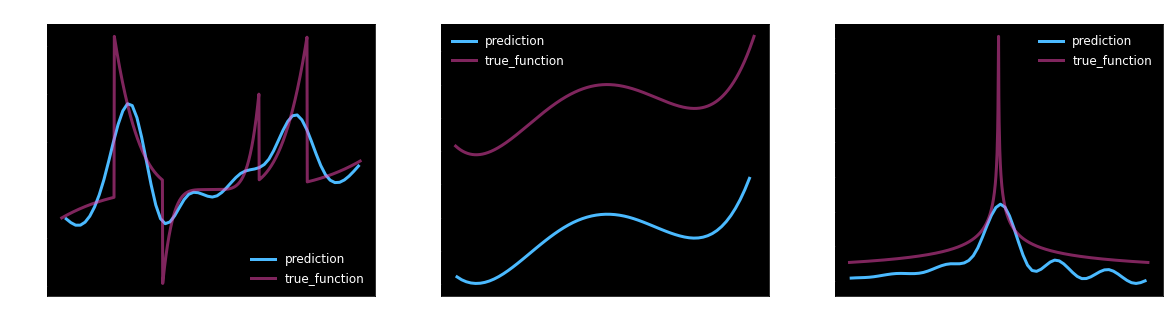

In [14]:
#hide_input
fig, axes = plt.subplots(1, len(X.columns), figsize=(20,5))
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    ax = axes[i] #works because intercept is always last term
    start = np.quantile(df[column],0.001)
    end = np.quantile(df[column],0.999)
    test_x = np.expand_dims(np.linspace(start,end,1000,dtype=np.float32),axis=1)
    function = functions[columns[i]]
    true_y = np.asarray([function(x) for x in test_x])
    XX = gam.generate_X_grid(term=i)
    XX = XX[np.where((XX[:,i] > start) & (XX[:,i] < end))[0],:]
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    ax.plot(XX[:, term.feature], pdep, label='prediction')
    ax.plot(test_x, true_y, label="true_function", alpha=0.5)
    ax.set_title(repr(term))
    ax.legend()
plt.show()

## Additive Neural Networks

![](https://ryansaxe.com/images/nam.png)

### Example Code

In [15]:
from tensorflow.keras import layers, regularizers

#define a simple multi-layer perceptron
class MLP(tf.keras.Model):
    def __init__(
        self,
        name=None
    ):
        super().__init__(name=name)
        # relu helps learn more jagged functions if necessary.
        self.l1 = layers.Dense(8, activation='relu')
        # softplus helps smooth between the jagged areas from above
        #     as softplus is referred to as "SmoothRELU"
        self.l2 = layers.Dense(8, activation='softplus')
        self.l3 = layers.Dense(8, activation='softplus')
        self.l4 = layers.Dense(8, activation='softplus')
        self.output_layer = layers.Dense(1)
    
    def call(self, x, training=None):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        return self.output_layer(x)
    
#define a Neural Additive Model for n features
class NAM(tf.keras.Model):
    def __init__(
        self,
        n_features,
        name=None
    ):
        super().__init__(name=name)
        self.n_features = n_features
        # initialize MLP for each input feature
        self.components = [MLP() for i in range(n_features)]
        # create final layer for a linear combination of learned components
        self.linear_combination = tf.keras.layers.Dense(1)
    
    @tf.function
    def call(self, x, training=None):
        #split up by individual features
        individual_features = tf.split(x, self.n_features, axis=1)
        components = []
        #apply the proper MLP to each individual feature
        for f_idx,individual_feature in enumerate(individual_features):
            component = self.components[f_idx](individual_feature)
            components.append(component)
        #concatenate learned components and return linear combination of them
        components = tf.concat(components, axis=1)
        return self.linear_combination(components)

In [16]:
#hide_output
model = NAM(n_features=3)
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)
hist = model.fit(
    X.to_numpy(),
    y.to_numpy(),
    epochs=30,
    batch_size=32,
)

Train on 1000000 samples
Epoch 1/30
1000000/1000000 [==============================] - 54s 54us/sample - loss: 444.2797 - mean_absolute_error: 12.6371
Epoch 2/30
1000000/1000000 [==============================] - 53s 53us/sample - loss: 208.0670 - mean_absolute_error: 8.1620
Epoch 3/30
1000000/1000000 [==============================] - 54s 54us/sample - loss: 148.6408 - mean_absolute_error: 6.8304
Epoch 4/30
1000000/1000000 [==============================] - 53s 53us/sample - loss: 129.5516 - mean_absolute_error: 6.1808
Epoch 5/30
1000000/1000000 [==============================] - 53s 53us/sample - loss: 116.2816 - mean_absolute_error: 5.6118
Epoch 6/30
1000000/1000000 [==============================] - 54s 54us/sample - loss: 97.8085 - mean_absolute_error: 4.8869
Epoch 7/30
1000000/1000000 [==============================] - 54s 54us/sample - loss: 65.2332 - mean_absolute_error: 3.5235
Epoch 8/30
1000000/1000000 [==============================] - 53s 53us/sample - loss: 53.6560 - mean_

In [17]:
#hide_input
print('mean squared error:',hist.history['loss'][-1],'\tmean absolute error:',hist.history['mean_absolute_error'][-1])

mean squared error: 33.171770990338324 	mean absolute error: 2.0058768


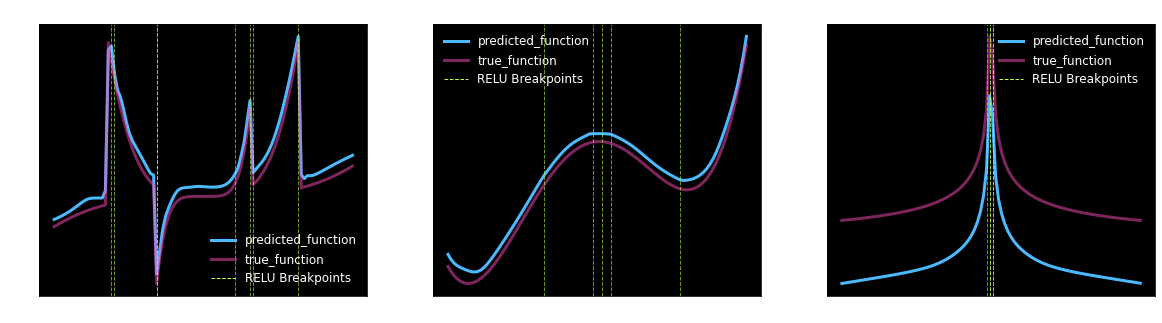

In [33]:
#hide_input
fig, axes = plt.subplots(1, len(X.columns), figsize=(20,5))
for f_idx, column in enumerate(X.columns):
    ax = axes[f_idx]
    multiplier = model.linear_combination.weights[0].numpy()[f_idx]
    start = np.quantile(df[column],0.999)
    end = np.quantile(df[column],0.001)
    test_x = np.expand_dims(np.linspace(start,end,100,dtype=np.float32),axis=1)
    function = functions[column]
    true_y = np.asarray([function(x) for x in test_x])
    pred_y = model.components[f_idx](test_x).numpy() * multiplier
    ax.plot(test_x, pred_y, label='predicted_function')
    ax.plot(test_x, true_y, label='true_function', alpha=0.5)
    relu_outs = model.components[f_idx].l1(test_x)
    vlines = 0
    for i in range(8):
        relu_out = relu_outs[:, i]
        nonzeros = np.where(relu_out)[0]
        if len(nonzeros) == 0:
            continue
        start = nonzeros.min()
        end = nonzeros.max()
        if start == 0 and end == 99:
            continue
        elif start == 0:
            val = test_x[end + 1][0]
        else:
            val = test_x[start - 1][0]
        ax.axvline(x=val, alpha=0.6, color=(186.0/255.0,1.0,75.0/255.0), ls="--", lw=1)
        vlines += 1
    title = f'function for column {column}'
    ax.set_title(title)
    relu_breaks = plt.Line2D((0,1),(0,0), color=(186.0/255.0,1.0,75.0/255.0), ls="--", lw=1)
    display = (0,1,2)

    handles, labels = ax.get_legend_handles_labels()

    #Create legend from custom artist/label lists
    ax.legend([handle for i,handle in enumerate(handles) if i in display]+[relu_breaks],
              [label for i,label in enumerate(labels) if i in display]+['RELU Breakpoints'])
    
plt.show()

At first glance, these results look good, but not perfect. While the Neural Additive Model was capable of learning the general shapes of the functions, it looks like it's off on the intercepts for all of them. This should not discount the validity of the model. The corresponding math demonstrates perfectly fitting intercepts of an additive model cannot be guaranteed. Our NAM is fitting the following function for n features:

$$y = \beta_0 + \sum_{i=1}^n \beta_i h_i(X_i)$$

Now, $h_i$ is some non-linear function learned via a multi-layer perceptron. Given that any function can have an intercept, we can say that $h_i(X_i) = \alpha_i + f(x_i)$ where $f(x_i)$ represents all of the aspects of $h(x_i)$ dependent on $x_i$.

$$
y & = \beta_0 + \sum_{i=1}^n \beta_i (\alpha_i + f_(X_i)) \\
y & = \beta_0 + \sum_{i=1}^n \beta_i \alpha_i + \sum_{i=1}^n \beta_i f_i(X_i)
$$

The only way to tease apart these intercepts is via $\beta$. Imagine the proper fit of this equation had $\beta_i = 1 \forall i$ and $\alpha_i = 2 \forall i$. In this case, the first half of $\alpha$ could be zero, and the second half could be four. That would yield the exact same result for $\sum_{i=1}^n \beta_i \alpha_i$ as the proper fit. Hence it is impossible to guarantee learning correct intercepts for any additive model.

In [19]:
#hide
intercepts = []
for f_idx, column in enumerate(X.columns):
    multiplier = model.linear_combination.weights[0].numpy()[f_idx]
    start = np.quantile(df[column],0.999)
    end = np.quantile(df[column],0.001)
    test_x = np.expand_dims(np.linspace(start,end,100000,dtype=np.float32),axis=1)
    function = functions[column]
    true_y = np.asarray([function(x) for x in test_x])
    pred_y = model.components[f_idx](test_x).numpy() * multiplier
    intercepts.append(np.average(pred_y - true_y))

In [20]:
#hide
def dxdy(x, y):
    return (x[1:] - x[:-1])/(y[1:] - y[:-1])

approximate the local derivative

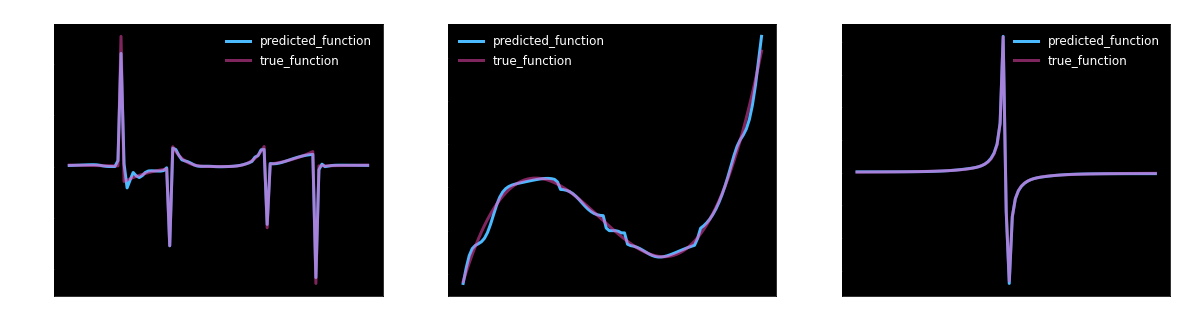

In [34]:
#hide_input
fig, axes = plt.subplots(1, len(X.columns), figsize=(20,5))
#fig2, axes2 = plt.subplots(1, len(X.columns), figsize=(20,5))
for f_idx, column in enumerate(X.columns):
    ax = axes[f_idx]
    multiplier = model.linear_combination.weights[0].numpy()[f_idx]
    start = np.quantile(df[column],0.999)
    end = np.quantile(df[column],0.001)
    test_x = np.expand_dims(np.linspace(start,end,100,dtype=np.float32),axis=1)
    function = functions[column]
    true_y = np.asarray([function(x) for x in test_x])
    pred_y = model.components[f_idx](test_x).numpy() * multiplier - intercepts[f_idx]
    relu_outs = model.components[f_idx].l1(test_x)
    vlines = 0
    for i in range(8):
        relu_out = relu_outs[:, i]
        nonzeros = np.where(relu_out)[0]
        if len(nonzeros) == 0:
            continue
        start = nonzeros.min()
        end = nonzeros.max()
        if start == 0 and end == 99:
            continue
        elif start == 0:
            val = test_x[end + 1][0]
        else:
            val = test_x[start - 1][0]
        #ax.axvline(x=val, alpha=0.5, color=(186.0/255.0,1.0,75.0/255.0), ls="--", lw=1)
        vlines += 1
    ax.plot(test_x[1:], dxdy(pred_y,test_x), label='predicted_function')
    ax.plot(test_x[1:], dxdy(true_y,test_x), label='true_function',alpha=0.5)
    title = f'derivative for column {column} with {vlines} learned breakpoints'
    ax.set_title(title)
    ax.legend()
plt.show()

# Interpretable Neural Networks

This is the fun part. This is where all your creativity for problem solving given domain knowledge yields an extremely flexible, powerful, and interpretable model!

## Priors

## Penalties

{{'The closed form solution for OLS is $\beta = (X^TX)^{-1}X^Ty$. This requires $X^TX$ to be invertible, which is the case when the elements in $X$ are linearly independent, which is satisfied by our assumption of independence. Without this, there is no closed form solution, and $\beta$ can be approximated by the maximum likelihood estimation function: $min_{\beta}(y - \beta X)^T(y - \beta X)$.' | fndetail: 1 }}

{{'The exponential family is a particular family of probability distributions containing an exponential in their probability density function. For further light reading on the topic, please refer to the [Wiki](https://en.wikipedia.org/wiki/Exponential_family).' | fndetail: 2 }}